### Reference

[生成对抗网络（GAN）之MNIST数据生成](https://zhuanlan.zhihu.com/p/28057434)

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/t10k-labels-idx1-ubyte.gz


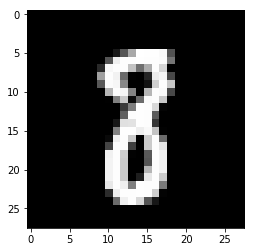

In [3]:
img = mnist.train.images[50]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [ ]:
def get_inputs(real_size, gen_vec_size):
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    gen_vec = tf.placeholder(tf.float32, [None, gen_vec_size], name='gen_vec')
    
    return real_img, gen_vec

## Activation: Leaky ReLU

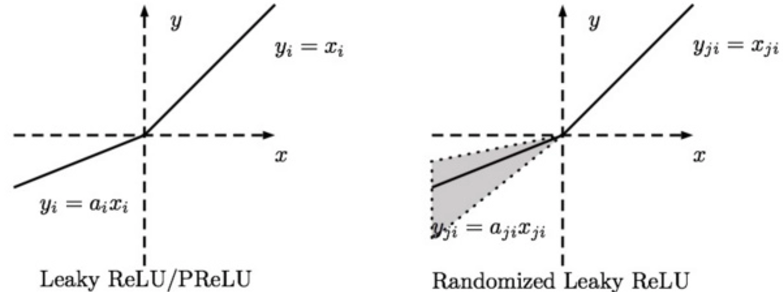

## Generator

In [ ]:
def get_generator(gen_vec, n_units, out_dim, reuse=False, alpha=0.01):
    with tf.variable_scope("generator", reuse=reuse):
        hidden1 = tf.layers.dense(gen_vec, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

## Discriminator

In [8]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    with tf.variable_scope("discriminator", reuse=reuse):
        hidden1 = tf.layers.dense(img, n_units)
        # Leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs
    

## Parameters

In [6]:
img_size = mnist.train.images[0].shape[0]
print(img_size)

gen_vec_size = 100
g_units = 128
d_units = 128
alpha = 0.01
learning_rate = 0.001
smooth = 0.1

784


## Graph

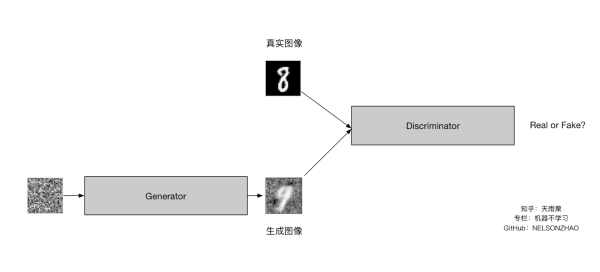

In [10]:
tf.reset_default_graph()

real_img, gen_vec = get_inputs(img_size, gen_vec_size)

# generator
g_logits, g_outputs = get_generator(gen_vec, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

#### Define Loss

In [11]:
# for real images, we want discriminator to mark it as "1"
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)) * (1 - smooth))

# for fake images, we want discriminator to mark it as "0"
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
d_loss = tf.add(d_loss_real, d_loss_fake)

# to generator, we want discriminator to mark "fake images" as "1"
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

#### Optimizer

In [12]:
train_vars = tf.trainable_variables()

g_vars = [var for var in train_vars if var.name.startswith("generator")]
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

# Training

In [20]:
batch_size = 64
epochs = 30
n_sample = 25

samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)

# start training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples // batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            
            # scaling
            batch_images = batch_images * 2 - 1
            
            # generator input
            batch_gen_vec = np.random.uniform(-1, 1, size=(batch_size, gen_vec_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, 
                                                 gen_vec: batch_gen_vec})
            
            _ = sess.run(g_train_opt, feed_dict={gen_vec: batch_gen_vec})
        
        # discriminator loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             gen_vec: batch_gen_vec})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                  gen_vec: batch_gen_vec})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 gen_vec: batch_gen_vec})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {gen_vec: batch_gen_vec})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, 
                                                                                  train_loss_d_real, 
                                                                                  train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    

        # for records
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # sampling for checking
        sample_gen_vec = np.random.uniform(-1, 1, size=(n_sample, gen_vec_size))
        gen_samples = sess.run(get_generator(gen_vec, g_units, img_size, reuse=True),
                               feed_dict={gen_vec: sample_gen_vec})
        samples.append(gen_samples)
        
        # checkpoints
        saver.save(sess, '/tmp/checkpoints_generator.ckpt')

# save samples
with open('/tmp/train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/30... Discriminator Loss: 0.0479(Real: 0.0051 + Fake: 0.0428)... Generator Loss: 3.9328
Epoch 2/30... Discriminator Loss: 0.3617(Real: 0.1911 + Fake: 0.1706)... Generator Loss: 5.5268
Epoch 3/30... Discriminator Loss: 3.6409(Real: 2.0977 + Fake: 1.5432)... Generator Loss: 0.8382
Epoch 4/30... Discriminator Loss: 3.2693(Real: 1.6386 + Fake: 1.6307)... Generator Loss: 0.8090
Epoch 5/30... Discriminator Loss: 1.8091(Real: 0.7542 + Fake: 1.0549)... Generator Loss: 0.6809
Epoch 6/30... Discriminator Loss: 1.0652(Real: 0.6266 + Fake: 0.4386)... Generator Loss: 1.0038
Epoch 7/30... Discriminator Loss: 1.6300(Real: 1.1132 + Fake: 0.5168)... Generator Loss: 1.3944
Epoch 8/30... Discriminator Loss: 2.6983(Real: 1.3230 + Fake: 1.3753)... Generator Loss: 0.6471
Epoch 9/30... Discriminator Loss: 2.8333(Real: 1.0737 + Fake: 1.7596)... Generator Loss: 0.3606
Epoch 10/30... Discriminator Loss: 2.5364(Real: 1.4017 + Fake: 1.1346)... Generator Loss: 0.5017
Epoch 11/30... Discriminator Loss: 2.10

## Plotting Losses

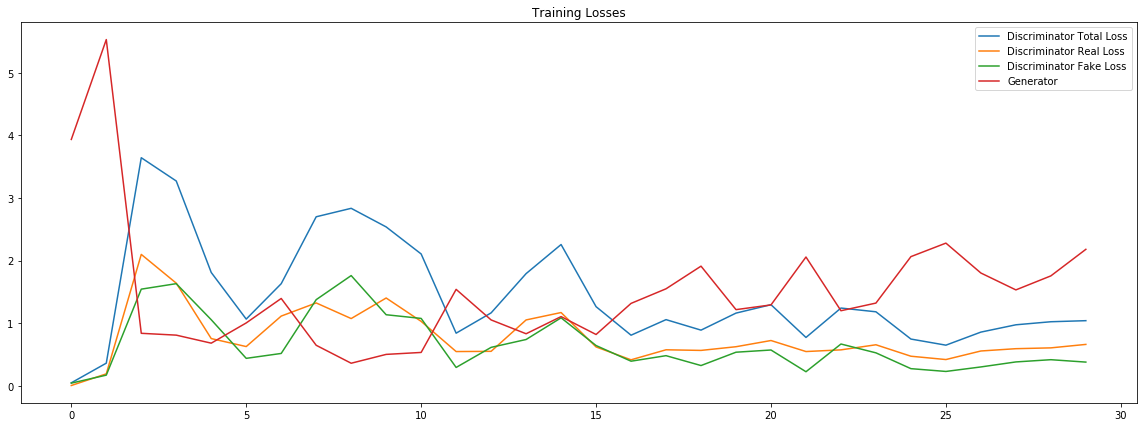

In [21]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Total Loss')
plt.plot(losses.T[1], label='Discriminator Real Loss')
plt.plot(losses.T[2], label='Discriminator Fake Loss')
plt.plot(losses.T[3], label='Generator')
plt.title("Training Losses")
plt.legend()

In [23]:
# Load samples from generator taken while training
with open('/tmp/train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

## View Generated Images 

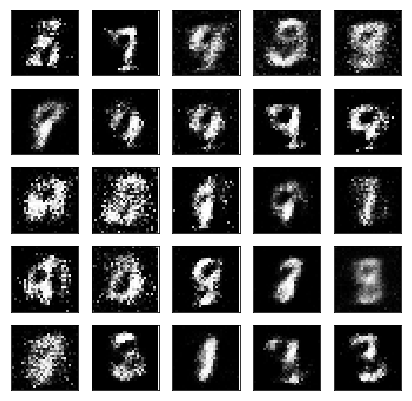

In [24]:
def view_samples(epoch, samples):
    """
    Args:
        epoch: the epoch samples to show
        samples: the sampling samples
    """
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    
    for ax, img in zip(axes.flatten(), samples[epoch][1]): 
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

_ = view_samples(-1, samples) # last epoch

## Show Image Generating Process

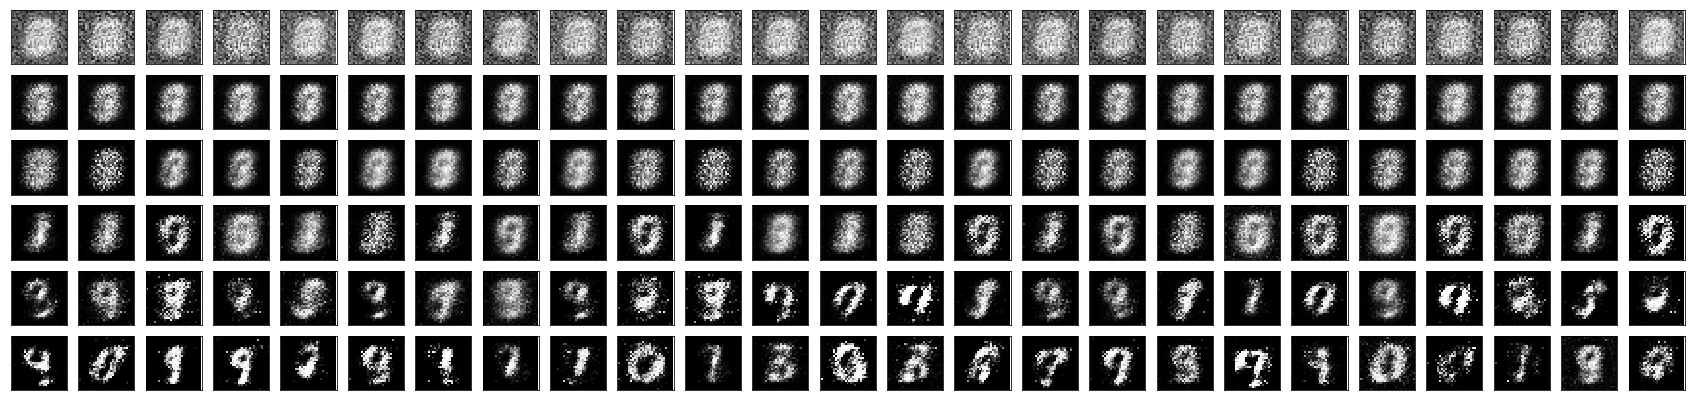

In [34]:
epoch_idx = range(0, epochs, 5)
show_imgs = []

for i in epoch_idx:    
    show_imgs.append(samples[i][1])

rows, cols = len(show_imgs), 25
fig, axes = plt.subplots(figsize=(30, 7), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Generate new images

INFO:tensorflow:Restoring parameters from /tmp/checkpoints_generator.ckpt


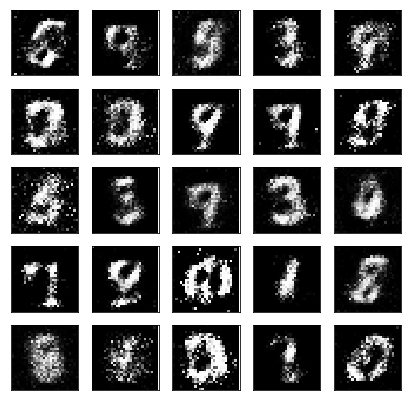

In [36]:
saver = tf.train.Saver(var_list=g_vars)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('/tmp'))
    sample_gen_vec = np.random.uniform(-1, 1, size=(25, gen_vec_size))
    gen_samples = sess.run(get_generator(gen_vec, g_units, img_size, reuse=True),
                           feed_dict={gen_vec: sample_gen_vec})

_ = view_samples(0, [gen_samples])